In [69]:
#loading dataset 

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
import os
import json
import urllib.request
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split



%matplotlib inline
fig = plt.figure(figsize=(20,5))

print(os.getcwd())


def load_data(data_dir):
    
    data = pd.read_csv(data_dir)

    #make amount into log value  :: when predicting use np.expm1(amount) to make it back to original amount size
    data['amount'] = np.log(data["amount"]) #log0 error 방지 
    data['three_month'] = np.log(data["three_month"])
    data['six_month'] = np.log(data["six_month"])
    data['twelve_month'] = np.log(data["twelve_month"])
    
 
    #one-hot-encoding ##
#     data = pd.get_dummies(data, columns = ['store_id']) 
    #'year','month' : not ordered store_id may need one hot encoding 
    #but year, month has order 
    
    #make values to category 
    data['store_id'] = data['store_id'].astype('category')
    data['month'] = data['month'].astype('category')
    
    #delete category and use train test split to split dataset 
    test = data[data['category']== 'test']
    data =data[data['category']!= 'test']
    
    del data['category']
    del test['category']
#     #split train/val/test
#     train = data[data['category'] == 'train']
#     val = data[data['category']=='val']
    
    X = data[['store_id', 'year', 'month', 'three_month', 'six_month' ,'twelve_month']]
    y =data['amount']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y , 

                                                    test_size=0.2, 

                                                    shuffle=True,

                                                    stratify=data['store_id'], 

                                                    random_state=1004)


    
    
    return X_train, X_val, y_train, y_val,test 
    
X_train, X_val, y_train, y_val,test  = load_data('/Users/janechoi/Desktop/연구학점/credit card/data/train_na.csv')

# X_train, X_val, y_train, y_val,test  = load_data('/Users/janechoi/Desktop/연구학점/credit card/data/train_mean_1.csv')

# X_train, X_val, y_train, y_val,test  = load_data('/Users/janechoi/Desktop/연구학점/credit card/data/train_median_1.csv')

# X_train, X_val, y_train, y_val,test  = load_data('/Users/janechoi/Desktop/연구학점/credit card/data/train_mean_nine_month.csv')


# X_train['store_id'].value_counts().index
y_val.isnull().sum()

/Users/janechoi/Desktop/연구학점/credit card/data


0

<Figure size 1440x360 with 0 Axes>

In [44]:
# LightGBM parameters
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold


avoid_cols = ['amount', 'category','year']
cols = [col for col in X_train.columns if col not in avoid_cols] #store_id, 3,6,12month, month 

# tscv = TimeSeriesSplit(n_splits=5) # 우리는 시계열로 자를수가 없음 :: store 이 한개가 아니기때문에 분리되는 방식이 이상해진다 . 

# gkf = list(GroupKFold(n_splits=5).split(X_train, y_train, X_train['store_id']))

skf = list(StratifiedKFold(n_splits=5,random_state=1008).split(X_train, X_train['store_id']))


scores=[]
def lgbm_pipline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, scoring_fit='neg_mean_absolute_error'):
                                   #why use neg_mean_squared_error: 사이킷런 교차검정은 클수록 좋은 효영함수를 기대:: 그래서 평균제곱오차(MSE)의 반댓값을 이용 
                                    #mean_absolute_error :: 우리의 목표 
                                    
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=skf, 
        n_jobs= -1, 
        scoring='neg_mean_absolute_error',
        verbose=True 
#         ,return_train_score = True
    )
    
    fitted_model = gs.fit(X_train_data, y_train_data, verbose=True, early_stopping_rounds=50, #과적합방지 
                         eval_metric = "mae",  eval_set=[(X_test_data, y_test_data)]) 
    
    #그리드마다 하나씩 fit 해보면서, early stopping round의 기준을 validation set 으로 잡는다. 
    
    
    #check the score for validation set 
    # gs.score :: Returns the score on the given data, if the estimator has been refit.
    
    score.append(gs.score(X_test_data,y_test_data)) 
    
#     pred = fitted_model.predict(X_test_data)
     
    return fitted_model,score 



#parameters 

#num_leaves의 개수를 중심으로 min_child_sampes(min_data_in_leaf), max_depth를 함께 조절하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

param_grid = {#only train with 5 main parameter 
    
    'num_leaves': [25, 50],  
    #we should let it be smaller than 2^(max_depth) 
    #max number of leaves in one tree
    
    'max_depth': [20,25,30], 
    #트리 최대 깊이 :과적합시 줄이기 
    
    'min_data_in_leaf' : [50,100,150], 
    #prevent overfitting ::  In practice, setting it to hundreds or thousands is enough for a large dataset.
    
    
    'num_iteration' : [2500,3000,4000], 
    
    'learning_rate': [0.05,0.1] ,
    
    
    
}

model = lgb.LGBMRegressor(task ='train',
                          boosting_type='dart',  
                          objective='regression',
                          save_binary =True,
                          metric='mae',
                          random_state=314 )
#                     is_training_metric= True) 

model,score = lgbm_pipline(X_train[cols], X_val[cols], 
                                y_train, y_val , 
                                model,  param_grid) #model is lgbm regressor 



#Look at the results of the cross validation model (this only uses the train dataset)
print(model.best_score_)
print(model.best_params_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 73.5min


KeyboardInterrupt: 

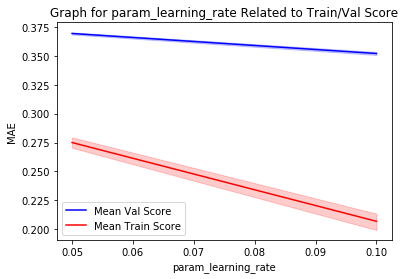

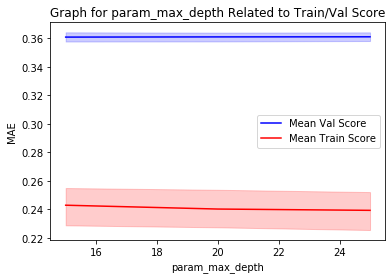

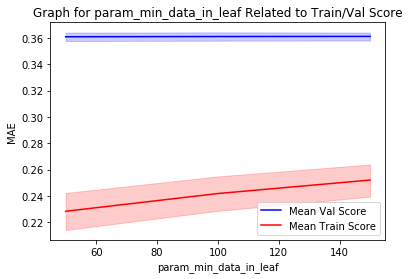

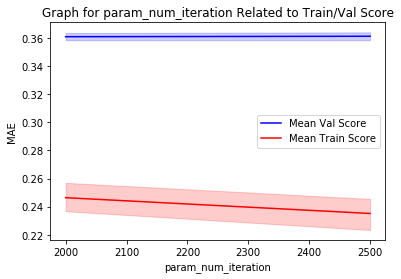

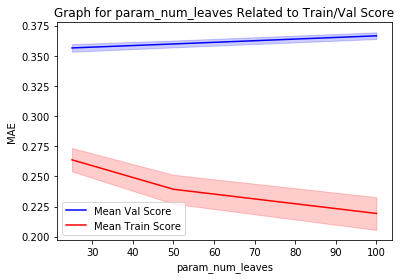

In [87]:
#visualization between meantestscore and parameter individually 

def graph_for_tuning(model):
    results = pd.DataFrame(model.cv_results_)
    results = results.iloc[:,[4,5,6,7,8,15]]
    results['mean_test_score'] = abs(results['mean_test_score']) #because we use negative change to absolute values 

    
    #CHANGE NAME BEFORE EXECUTING!!!!!!! 
    results.to_csv('LGBM_NAN_3.csv', index=False)

    
    #DRAWING A PLOT!!! 
    for params in results.columns[:5]:
        sns.lineplot(x=params , y='mean_test_score', color='blue', data=results,label= 'Mean TEST Score')
#         sns.lineplot(x=params , y='mean_train_score', color='red', data=results, label = 'Mean Train Score')
        plt.title('Graph for '+str(params)+' Related to TEST Score for CV')
        plt.ylabel('MAE')
        plt.show()
        
    return results


results =graph_for_tuning(model)

#{'learning_rate': 0.1, 'max_depth': 20, 'min_data_in_leaf': 50, 'num_iteration': 2500, 'num_leaves': 25}

#visualization between two parameters 
def heatmap_visualization(index,columns):

    pvt = pd.pivot_table(results,values='mean_test_score', index=index, columns=column)
    ax = sns.heatmap(pvt)
    plt.show()
    
    

# heatmap_visualization('param_min_data_in_leaf','param_max_depth')

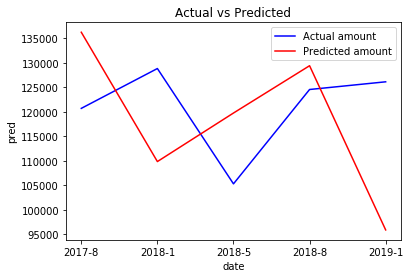

In [92]:
#draw a graph to see if the data is well fitted 


def draw_prediction_plot(X_val):
    #preprocess validation set 
    pred = model.best_estimator_.predict(val[cols])
    pred_amount = np.exp(pred)
    X_val['pred'] =pred_amount
    X_val['amount'] = np.exp(y_val)
    X_val['date'] = X_val['year'].astype(str) + '-' + X_val['month'].astype(str)
    
    for i in X_val['store_id'].unique():
    #draw a line plot for the store id i 
        sns.lineplot(x='date' , y='amount',color='blue', data= X_val[X_val['store_id'] == i],label='Actual amount')
        sns.lineplot(x='date' , y='pred',data= X_val[X_val['store_id'] == i], color = 'red',label = 'Predicted amount')
        plt.title('Actual vs Predicted for store id ' + str(i))
        plt.show()

    return X_val 
draw_prediction_plot(X_val) #look for ((830, 619,271))

In [12]:
#making a submission file 

# cols,m = lgbm_cv('seven_month')
def make_submission(model, test, name):
    #make prediction of 795 store to zero (only has 2 observations)
#     l = test.loc[(test.store_id == 795)].index
#     test.drop(index=l, inplace=True)
    
    test_pred_y = model.predict(test[cols])
    test_pred_y = np.exp(test_pred_y)
    test['amount'] =test_pred_y
    
    store= pd.DataFrame(data=[[795,0]],columns=['store_id', 'amount'])
    test= pd.concat([test,store])
    
    grouped_ww = test.groupby('store_id')['amount']
    
    submission = pd.DataFrame(grouped_ww.sum())
    

    submission.reset_index(inplace=True)
#     print(submission)
    submission.to_csv(str(name)+'.csv', index=False)
    
    
    return submission
    
sub= make_submission(m,test,'submission_full_median_LGBM_random_without_seven_bay')

sub

